In [ ]:
!rm -rf /root/.kaggle
!mkdir -p /root/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"watson0327","key":"af4bff00976c22068c075bfbf6fd00c1"}'}

In [ ]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mohitsingh1804/plantvillage --unzip

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 97% 790M/818M [00:04<00:00, 39.3MB/s]
100% 818M/818M [00:04<00:00, 195MB/s] 


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import os

DATASET_PATH = 'PlantVillage'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VAL_DIR = os.path.join(DATASET_PATH, 'val')
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

try:
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_BASE_PATH = '/content/drive/MyDrive/plant_disease_models_scratch'
    print(f"Google Drive mounted. Checkpoints will be saved to: {GDRIVE_BASE_PATH}")
except ImportError:
    print("Not in Google Colab. Saving checkpoints to local directory.")
    GDRIVE_BASE_PATH = '.'

CHECKPOINT_DIR = os.path.join(GDRIVE_BASE_PATH, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_FILEPATH = os.path.join(CHECKPOINT_DIR, 'model_epoch_{epoch:02d}.h5')

Mounted at /content/drive
Google Drive mounted. Checkpoints will be saved to: /content/drive/MyDrive/plant_disease_models_scratch


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='constant',
    cval=127
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

def count_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

num_train_samples = count_files(TRAIN_DIR)
num_val_samples = count_files(VAL_DIR)
steps_per_epoch = num_train_samples // BATCH_SIZE
validation_steps = num_val_samples // BATCH_SIZE
class_names = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(class_names)

print(f"Found {num_train_samples} training images belonging to {NUM_CLASSES} classes.")
print(f"Found {num_val_samples} validation images.")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.
Found 43444 training images belonging to 38 classes.
Found 10861 validation images.
Steps per epoch: 1357
Validation steps: 339


In [ ]:
 model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("\n--- Starting model training ---")
checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_FILEPATH,
    save_weights_only=False, # Save the full model
    save_freq='epoch',
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,095,654 (225.43 MB)

 Trainable params: 59,095,654 (225.43 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting model training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.4056 - loss: 2.2821
Epoch 1: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_01.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 692s 503ms/step - accuracy: 0.4057 - loss: 2.2816 - val_accuracy: 0.7626 - val_loss: 0.7880
Epoch 2/10
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 2:04 92ms/step - accuracy: 0.7812 - loss: 0.8574

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_02.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.7812 - loss: 0.8574 - val_accuracy: 0.7454 - val_loss: 0.8651
Epoch 3/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7451 - loss: 0.8345
Epoch 3: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_03.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 693s 495ms/step - accuracy: 0.7451 - loss: 0.8345 - val_accuracy: 0.8666 - val_loss: 0.4075
Epoch 4/10
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 1:58 88ms/step - accuracy: 0.7188 - loss: 0.7528
Epoch 4: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_04.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7188 - loss: 0.7528 - val_accuracy: 0.8645 - val_loss: 0.4202
Epoch 5/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8097 - loss: 0.6133
Epoch 5: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_05.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 688s 507ms/step - accuracy: 0.8098 - loss: 0.6133 - val_accuracy: 0.8334 - val_loss: 0.5939
Epoch 6/10
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 1:58 87ms/step - accuracy: 0.8438 - loss: 0.7636
Epoch 6: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_06.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8438 - loss: 0.7636 - val_accuracy: 0.8548 - val_loss: 0.4941
Epoch 7/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8410 - loss: 0.5040
Epoch 7: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_07.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 744s 525ms/step - accuracy: 0.8410 - loss: 0.5040 - val_accuracy: 0.8889 - val_loss: 0.3522
Epoch 8/10
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 2:00 89ms/step - accuracy: 0.8438 - loss: 0.4653
Epoch 8: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_08.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8438 - loss: 0.4653 - val_accuracy: 0.8909 - val_loss: 0.3490
Epoch 9/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8661 - loss: 0.4205
Epoch 9: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_09.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 676s 493ms/step - accuracy: 0.8661 - loss: 0.4205 - val_accuracy: 0.9241 - val_loss: 0.2389
Epoch 10/10
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 1:59 88ms/step - accuracy: 0.8750 - loss: 0.4242
Epoch 10: saving model to /content/drive/MyDrive/plant_disease_models_scratch/checkpoints/model_epoch_10.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.8750 - loss: 0.4242 - val_accuracy: 0.9266 - val_loss: 0.2333



--- Evaluating the model on the validation set ---
339/339 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.9253 - loss: 0.2380
Final Validation Loss: 0.2339
Final Validation Accuracy: 0.9264

--- Plotting training history ---


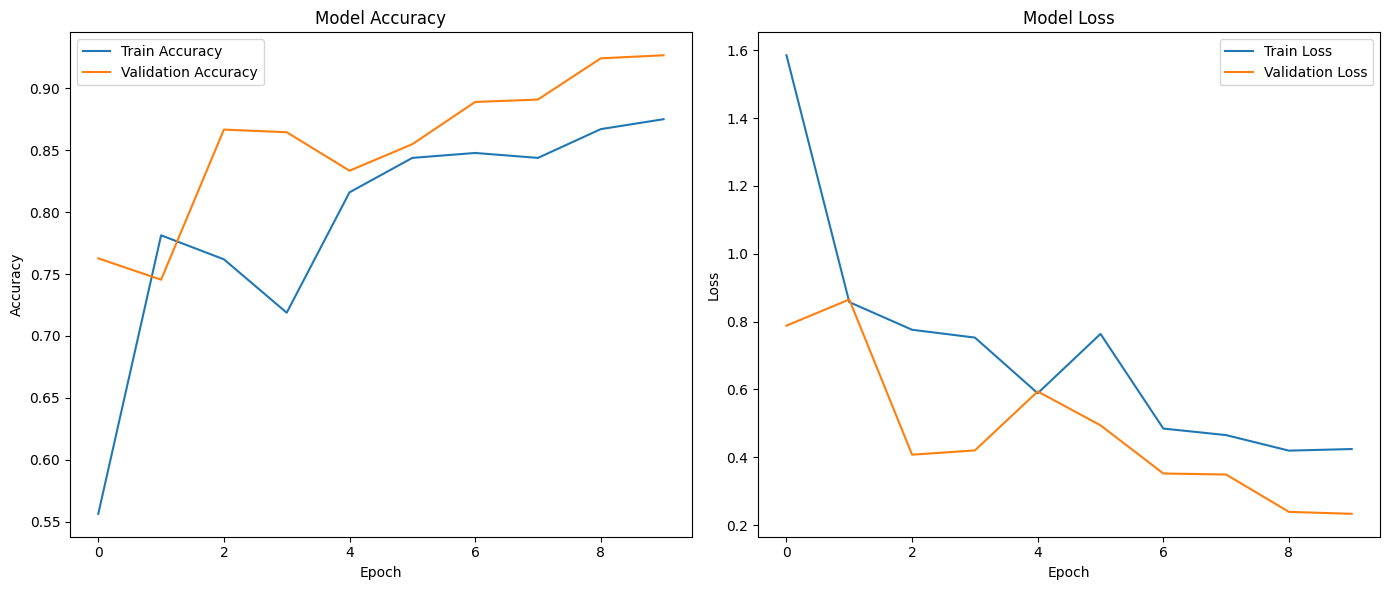

In [ ]:
print("\n--- Evaluating the model on the validation set ---")
loss, accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Final Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy:.4f}")

print("\n--- Plotting training history ---")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


--- Making a prediction on a sample image ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True Label: Apple___healthy
Predicted Label: Apple___healthy with 90.36% confidence


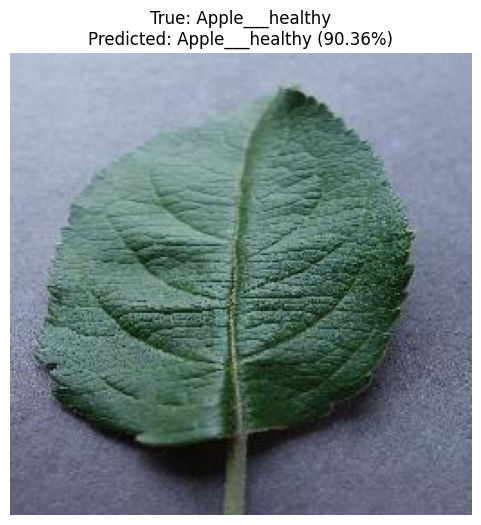

In [ ]:
print("\n--- Making a prediction on a sample image ---")
sample_images, sample_labels = next(validation_generator)
sample_image = sample_images[0]
true_label_one_hot = sample_labels[0]

true_label_index = np.argmax(true_label_one_hot)
true_label_name = class_names[true_label_index]

input_image = np.expand_dims(sample_image, axis=0)
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions[0]) * 100

print(f"True Label: {true_label_name}")
print(f"Predicted Label: {predicted_class_name} with {confidence:.2f}% confidence")

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.title(f"True: {true_label_name}\nPredicted: {predicted_class_name} ({confidence:.2f}%)")
plt.axis('off')
plt.show()